This is more or less a test to figure out how to create repositories, etc

In [2]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project`


In [3]:
Pkg.add("Plots")
using Plots # plotting
Pkg.add("LinearAlgebra")
using LinearAlgebra
Pkg.add("CSV")
using CSV
Pkg.add("DataFrames")
using DataFrames

   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Project.toml`
  No Changes to `~/Desktop/fall 2023/cee 4750/final project/Elliot-Leah-Mark-final-project/Manifest.toml`


Below starts the actual code. Steps as defined in project update.

## 0. cell matrices ##

In [4]:

#=
map_area=[
    0 .2 1 1 1
    .5 1 1 1 .2
    1 1 .3 0 0]; #fraction of each cell within watershed, FIXME
    =#

#=
map_ag=[
    0 .1 .5 .7 .6
    .2 .7 1 .4 .1
    0 1 .2 0 0]; #ag coefficient of each cell, FIXME
=#

#curve numbers, from soil series -> hydraulic soil types -> weighted 
#avg approximation based on crop type and other land use
#ADJUST, FIXME
#map_CN=90*ones(height_watershed_cells, width_watershed_cells);

#=
map_elevation=[
    20 40 10 10 8
    30 20 15 13 80
    20 10 40 40 40]; #height above outlet, FEET, FIXME
=#


areaDataFrame=CSV.read("map area.csv", DataFrame, header=false, delim=',');
map_area=Matrix(areaDataFrame);


length_cell=304.8; #m, equiv to 1000 ft FIXME
height_watershed_cells=length(map_area[:,1]); #number of cells
width_watershed_cells=length(map_area[1,:]); #number of cells

number_cells_total=height_watershed_cells*width_watershed_cells; #number of cells
area_cell= length_cell^2; #m^2



agDataFrame=CSV.read("map ag.csv", DataFrame, header=false, delim=',');
map_ag=Matrix(agDataFrame);

bareDataFrame=CSV.read("map bare.csv", DataFrame, header=false, delim=',');
map_bare=Matrix(bareDataFrame);

developedDataFrame=CSV.read("map developed.csv", DataFrame, header=false, delim=',');
map_developed=Matrix(developedDataFrame);

treesDataFrame=CSV.read("map trees.csv", DataFrame, header=false, delim=',');
map_trees=Matrix(treesDataFrame);


#FIXME maybe combine ag+bare

#possible soil types are A, B, C, D, A/D, B/D, C/D, denoted as 1, 2, 3, 4, 5, 6, 7 
#0 is not in watershed so hopefully irrelevant
#value indicates majority/plurality soil type in grid square occupied by watershed
soilDataFrame=CSV.read("map soil.csv", DataFrame, header=false, delim=',');
map_soil=Matrix(soilDataFrame);

map_soil[map_soil.>4] .= 4; #all composite types are treated as D

map_soil=Int.(map_soil);

map_CN=zeros(height_watershed_cells, width_watershed_cells);

map_CN_ag=zeros(height_watershed_cells, width_watershed_cells);

map_CN_nonag=zeros(height_watershed_cells, width_watershed_cells);

#down: A, B, C, D
#across: ag, bare, developed, trees (ag as straight row good cond; bare as poor cond w/ residue; 
#developed as small lot town houses; trees as fair cond forest)
values_CN=[67 76 77 36
78 85 85 70
85 90 90 73
89 93 92 79];

for i=1:height_watershed_cells
    for j=1:width_watershed_cells
        if map_soil[i,j] !=0
            #map_CN[i,j]=map_ag[i,j]*values_CN[map_soil[i,j],1]
            total_calc_area=map_ag[i,j]+map_bare[i,j]+map_developed[i,j]+map_trees[i,j];

            map_CN[i,j]=(map_ag[i,j]*values_CN[map_soil[i,j],1]+map_bare[i,j]*values_CN[map_soil[i,j],2]
            +map_developed[i,j]*values_CN[map_soil[i,j],3]+map_trees[i,j]*values_CN[map_soil[i,j],4])/total_calc_area;

            map_CN_ag[i,j]=values_CN[map_soil[i,j],1];  #FIXME if combining bare land adjust this too

            map_CN_nonag[i,j]=(map_bare[i,j]*values_CN[map_soil[i,j],2]
            +map_developed[i,j]*values_CN[map_soil[i,j],3]+map_trees[i,j]*values_CN[map_soil[i,j],4])/(total_calc_area-map_ag[i,j]); 
            #FIXME if combining bare land w/ ag adjust this

        end
    end
end



outlet_cell_coords=[7,1];

map_distance=zeros(height_watershed_cells, width_watershed_cells);
for i in 1:height_watershed_cells
    for j in 1:width_watershed_cells
        map_distance[i,j] = length_cell*sqrt((i-outlet_cell_coords[1])^2+(j-outlet_cell_coords[2])^2);
    end
end

elevationDataFrame=CSV.read("map elevation.csv", DataFrame, header=false, delim=',');
map_elevation=Matrix(elevationDataFrame);

In [ ]:
map_ag .+ map_bare .+ map_developed .+ map_trees

## 1. calculating manure and phosphorus ##

In [26]:
depth_applied=.5; #inches, ADJUST FIXME
depth_mixed=.5; #inches, ADJUST FIXME

d_interacting= 0.5*depth_applied/depth_mixed*2.54/100; #m

density_manure=63*16.0185; #kg/m^3

#from Pagliari, 2014
phosphorus_in_manure_amount=10.55 #g/kg
inorg_fract=.695;

## 2. calculating idealized storm ##

In [70]:
#CURRENTLY: _____ FIXME tweak this
precip_storm_total=1.91*25.4; #mm, to be tweaked
duration_storm=60*12; #min, to be tweaked

intensity_storm=precip_storm_total/duration_storm; #mm/min

## 3. defining calculations for each cell ##

In [73]:
t_runoff_start_ag_matrix=zeros(height_watershed_cells, width_watershed_cells); #minutes
t_runoff_start_nonag_matrix=zeros(height_watershed_cells, width_watershed_cells); #minutes
t_c_matrix=zeros(height_watershed_cells, width_watershed_cells); #minutes
vol_ag_matrix=zeros(height_watershed_cells, width_watershed_cells); #m^3
vol_nonag_matrix=zeros(height_watershed_cells, width_watershed_cells); #m^3
C_ag_matrix=zeros(height_watershed_cells, width_watershed_cells); #g/m^3

number_mins=1000; #length of time arrays

rate_vol_outlet=1.566*49.3/38.6*ones(number_mins); #m^3/sec, array, per minute; calculations are area scaling
C_outlet=11.396*ones(number_mins); #μg/L baseflow concentration, array, per minute; baseflow concentration=11.396

M_runoff_series=zeros(number_mins); #g, FIXME maybe use this

M_cumulative=0;

runoff_cumulative=0;

for i in 1:height_watershed_cells
    for j in 1:width_watershed_cells
        area_cell_inside=area_cell*map_area[i,j];
        if area_cell_inside>0
            area_ag=area_cell_inside*map_ag[i,j];
            CN=map_CN[i,j];

            CN_ag=map_CN_ag[i,j];
            CN_nonag=map_CN_nonag[i,j];
            distance=map_distance[i,j];
            
            S_ag=25400/CN_ag-254; #mm
            Ia_ag=0.2*S_ag; #mm
    
            S_nonag=25400/CN_nonag-254; #mm
            Ia_nonag=0.2*S_nonag; #mm
    
            depth_Q_ag=0;
            if precip_storm_total>Ia_ag
                depth_Q_ag=(precip_storm_total-Ia_ag)^2/(precip_storm_total-Ia_ag+S_ag); #mm
            end
            vol_Q_ag=depth_Q_ag*area_cell_inside*map_ag[i,j]/1000; #m^3
            vol_Q_ag_liters=vol_Q_ag*1000;
    
    
            depth_Q_nonag=0;
            if precip_storm_total>Ia_nonag
                depth_Q_nonag=(precip_storm_total-Ia_nonag)^2/(precip_storm_total-Ia_nonag+S_nonag)
            end    
            vol_Q_nonag=depth_Q_nonag*(area_cell_inside-area_ag)/area_cell_inside;
             
            
            vol_Q=vol_Q_ag+vol_Q_nonag;
            depth_Q=vol_Q/area_cell_inside;

            runoff_cumulative+=vol_Q;
    
            t_runoff_start_ag=0; #FIXME this couldbe causing issues
            if depth_Q_ag>0
                t_runoff_start_ag=duration_storm*Ia_ag/precip_storm_total; #mins
            end
            
            t_runoff_start_nonag=0;
            if depth_Q_nonag>0
                t_runoff_start_nonag=duration_storm*Ia_nonag/precip_storm_total; #mins
            end

            rate_vol_Q_ag=vol_Q_ag/(duration_storm-t_runoff_start_ag)/60; #m^3/sec, for individual cell
            rate_vol_Q_nonag=vol_Q_nonag/(duration_storm-t_runoff_start_nonag)/60; #m^3/sec, for individual cell


            #=
            if t_runoff_start<duration_storm #FIXME could be causing issues
                rate_vol_Q=vol_Q/(duration_storm-t_runoff_start)/60; #m^3/sec, for individual cell
            else
                rate_vol_Q=0;
            end
    =#


            #println(rate_vol_Q_ag); #FIXME TEMP


            #------------ MANURE STARTS HERE -------------
            
            M_interacting_manure=d_interacting*density_manure*area_ag; #kg
            M_interacting_inorg=M_interacting_manure*.733; #g
            
            M_dissolved_inorg=0; #g
            #piecewise function built from plot in Pagliari, 2014
            
            if 0<vol_Q_ag_liters/M_interacting_manure<=12.5
                M_dissolved_inorg=((vol_Q_ag_liters/M_interacting_manure-1.7)/10.8*.44+.07)/100*M_interacting_inorg; #g
            elseif 12.5<vol_Q_ag_liters/M_interacting_manure <= 50.8
                M_dissolved_inorg=((vol_Q_ag_liters/M_interacting_manure-12.5)/(50.8-12.5)*.46+.51)/100*M_interacting_inorg; #g
            elseif 50.8<vol_Q_ag_liters/M_interacting_manure
                M_dissolved_inorg=((vol_Q_ag_liters/M_interacting_manure-50.8)/(101.7/50.8)*(0-.06)+.97)/100*M_interacting_inorg; #g
            end
    
            #=
            #TRIAL PURPOSES, DON'T USE
            if vol_Q_ag>0
                M_dissolved_inorg=100; #FIXME TEMP
            end
            =#
            
            if !isnan(M_dissolved_inorg)
                M_cumulative += M_dissolved_inorg; #g, doesn't consider baseflow phosphorus
            end

            

            t_runoff_start_ag_matrix[i,j]=t_runoff_start_ag;
            t_runoff_start_nonag_matrix[i,j]=t_runoff_start_nonag;
            t_c_matrix[i,j]=0.0078*map_distance[i,j]^0.77/(map_elevation[i,j]/map_distance[i,j])^0.385; #minutes
            vol_ag_matrix[i,j]=vol_Q_ag;
            vol_nonag_matrix[i,j]=vol_Q_nonag;
            

            if !isnan(M_dissolved_inorg) && vol_Q_ag != 0 #avoid NaN values in the concentration matrix when no runoff is occurring, etc
                C_ag_matrix[i,j]=M_dissolved_inorg/vol_Q_ag*1000; #μg/L
            end

            #=
            if(abs(M_dissolved_inorg-C_ag_matrix[i,j]*rate_vol_Q_ag*(duration_storm-t_runoff_start_ag)/1000*60)>.01)
                println("bad")
            end
            =#

            #println(M_dissolved_inorg)
            #println(C_ag_matrix[i,j]*rate_vol_Q_ag*(duration_storm-t_runoff_start_ag)/1000)

            #println(C_ag_matrix[i,j]*rate_vol_Q_ag*(duration_storm-t_runoff_start_ag)/1000); #FIXME TEMP
            
    
            
            for k=1:length(rate_vol_outlet)
                #FIXME ISSUE IN HERE
                #if t_runoff_start <= k < duration_storm
                if t_runoff_start_ag+t_c_matrix[i,j] <=  k < duration_storm+t_c_matrix[i,j] #removed t_runoff_start_ag+
                    M_runoff_series[k]+=C_ag_matrix[i,j]*rate_vol_Q_ag*60; #g, alternate method, THIS IS CURRENTLY CONSISTANT W/ SANITY CHECK
                    
                    temp_C_outlet=(C_outlet[k]*rate_vol_outlet[k] + C_ag_matrix[i,j]*rate_vol_Q_ag)/(rate_vol_outlet[k]+rate_vol_Q_ag); #μg/L
                    C_outlet[k] = temp_C_outlet;
                    rate_vol_outlet[k] += (rate_vol_Q_ag);
                end
                
                
                if t_runoff_start_nonag+t_c_matrix[i,j] <=  k <= t_runoff_start_nonag+duration_storm+t_c_matrix[i,j]
                    temp_C_outlet=(C_outlet[k]*rate_vol_outlet[k])/(rate_vol_outlet[k]+rate_vol_Q_nonag); #μg/L
                    C_outlet[k] = temp_C_outlet
                    rate_vol_outlet[k] += (rate_vol_Q_nonag); #m^3/sec
                end
                
            end
            
        end
    end
end


println("Mass from runoff is ",M_cumulative/1000, " kg"); #returns cumulative mass in kg
println("Mass from baseflow is ", 1.566 *49.3/38.6*number_mins*60*11.396/1000/1000, " kg") #reasonably sure this is correct
println("(Sanity check): Total mass is ", dot(rate_vol_outlet, transpose(C_outlet))/1000/1000*60, " kg");

Mass from runoff is 3.956759786285891 kg
Mass from baseflow is 1.3675873131606218 kg
(Sanity check): Total mass is 5.3249125831698345 kg


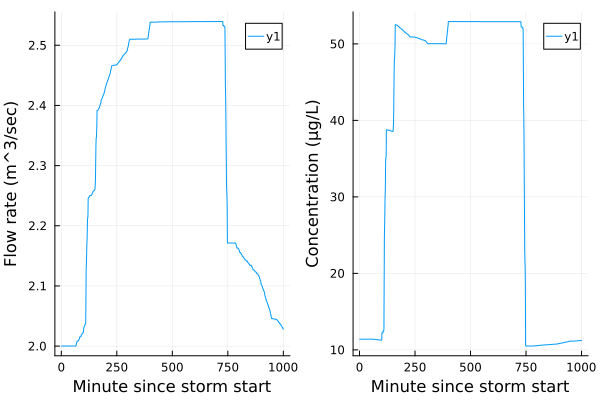

In [72]:
plot_flow=plot(1:number_mins, rate_vol_outlet, xlabel="Minute since storm start", ylabel="Flow rate (m^3/sec)")
plot_C=plot(1:number_mins, C_outlet, xlabel="Minute since storm start", ylabel="Concentration (μg/L)")
plot(plot_flow, plot_C)
